# EWpredict

The goal of this project is to utilize machine learning algorithms to catagorize seismic records based on information produced by [Empirical Wavelet Method](https://github.com/Leviyu/EQTime). 

Being able to automatically predict the quality (accept or reject) of seismic record combined with Empriical Wavelet Making mathod would allows us to build seismic dataset in a fast, systematical and consistant manner. And being able to do so, would allow us to establish first step towards a new era for seismology. 

In [57]:
# Import Necessary Library

import sys
import pandas as pd 
import matplotlib as plt
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time

import warnings
warnings.filterwarnings("ignore")
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [58]:
# read in accpeted record flag
picked_flag = "picked_flag.csv"
keep = pd.read_csv(picked_flag,sep=' ')
print(keep.FLAG)

0             199401101553_SB09_SS
1             199401101553_SB10_SS
2               199401101553_ARC_S
3             199401101553_ARC_ScS
4               199401101553_BKS_S
5             199401101553_BKS_ScS
6          199401101553_BKS_ScSScS
7               199401101553_CMB_S
8             199401101553_CMB_ScS
9               199401101553_MHC_S
10              199401101553_ORV_S
11            199401101553_ORV_ScS
12             199401101553_PKD1_S
13           199401101553_PKD1_ScS
14        199401101553_PKD1_ScSScS
15              199401101553_SAO_S
16         199401101553_SAO_ScSScS
17             199401101553_STAN_S
18           199401101553_STAN_ScS
19              199401101553_WDC_S
20            199401101553_WDC_ScS
21              199401101553_YBH_S
22            199401101553_YBH_ScS
23         199401101553_YBH_ScSScS
24           199401101553_CDCB_ScS
25           199401101553_FRMB_ScS
26        199401101553_FRMB_ScSScS
27           199401101553_FURB_ScS
28        1994011015

In [59]:
# Read in dataset
data_file = "eventinfo.EWPredict2.csv"
data = pd.read_csv(data_file,sep='\ ')

In [60]:
data.SNR_TROUGH.max()

0.0

In [61]:
# Define new PICK flag based on whether the record exist in picked_flag.csv
y = data["EQ_NAME_STA_PHASE"].isin(keep.FLAG).astype(int)
data['DECISION'] = y
# data['DECISION']
## Check pick rate amont all data
# 1 is accpeted
# 0 is rejected

pick_info = y.value_counts()
pick_rate = pick_info[1]/(pick_info[0]+pick_info[1])
print("Total number of records is: {:.0f}".format(y.shape[0]))
print("Totle number of records accepted is: {:.0f}".format(pick_info[1]))
print(" Accept Rate by Human check is: {:.2f}%".format(pick_info[1]/y.shape[0]*100))


Total number of records is: 28298
Totle number of records accepted is: 5363
 Accept Rate by Human check is: 18.95%


In [62]:
# Now we have our data
# data : the measurement
# y: our final classification result

## Step1: Define the Problem

Background: 
Though automated processing code I developed during my Ph.D. [EQTime](https://github.com/Leviyu/EQTime), I have collected a huge seismic dataset. The dataset consists of many scientific measurements as well as quality measurements. The nature of seismology is to identify confident signal from background noise. The dataset that I have gather contains records that can be used for seismic study and those that are too noise/or have other issues and thus should be rejected.

Each record should be classified into two catagories:
* Reject
* Accept

For the dataset that I have gathered, we have manually went through the dataset and make decision whether to accept or reject each record. Our goal is to see if we can use machine learning algorithm to learn our decision choices.

This is a classic binary classification problem in machine learning.

## Data Exploration

In [63]:
data.head()

,STA,NET,DIST,AZ,BAZ,STA_LAT,STA_LON,EQ_LAT,EQ_LON,EQ_DEP,...,PRE3T,BAK2T,BAK3T,SNR_TROUGH,SNR_PEAK,SNR_SMALL,TRAFFIC_IN_NOISE,ONE_PERIOD,EQ_NAME_STA_PHASE,DECISION
0,INCN,IU,35.589,0.669,180.840,37.478,126.624,1.718,126.135,107.1,...,0.67,0.72,0.29,0.0,0.0,0,0,0.0,199602280944_INCN_ScSScS,0
1,BGCA,GT,107.469,275.933,86.580,5.176,18.424,1.718,126.135,107.1,...,-0.00,0.46,-0.00,0.0,0.0,0,1,33.0,199602280944_BGCA_ScSScS,0
2,EVO,G,121.840,318.513,57.594,38.532,-8.013,1.718,126.135,107.1,...,0.05,0.07,0.07,0.0,0.0,0,0,26.8,199602280944_EVO_ScSScS,0
3,KOG,G,173.029,350.660,9.374,5.207,-52.732,1.718,126.135,107.1,...,-0.00,0.23,0.45,0.0,0.0,0,0,27.4,199602280944_KOG_ScSScS,0
4,TATO,IU,23.550,349.417,168.330,24.974,121.497,1.718,126.135,107.1,...,0.16,0.72,0.39,0.0,0.0,0,0,0.0,199602280944_TATO_ScSScS,0


In [64]:
# Check for null value and clean
data.NET.fillna("NNN",inplace=True)
data = data.dropna()
data.isnull().sum()

STA                  0
NET                  0
DIST                 0
AZ                   0
BAZ                  0
STA_LAT              0
STA_LON              0
EQ_LAT               0
EQ_LON               0
EQ_DEP               0
EQ_MAG               0
EQ_NAME              0
POLARFLAG            0
QUALITY              0
PREM                 0
AMP                  0
CCC1                 0
SNRAVE               0
DT                   0
PHASE                0
STRETCHC             0
STRETCHF             0
MISFITSIG            0
COMP                 0
TAG1                 0
TAG2                 0
TAG3                 0
TAG4                 0
TAG5                 0
WEIGHT               0
TAG6                 0
TAG7                 0
ONSET                0
ENDSET               0
TSTARF               0
TSTARC               0
CCC2                 0
MISFITPRE            0
MISFITBAK            0
GRECORD              0
GSEW                 0
GMISFIT              0
POLARITY             0
POLAR_RIGHT

In [65]:
print("size of data is {}".format(data.shape))

size of data is (28293, 56)


In [66]:
# check the existing column
list(data.columns)


['STA',
 'NET',
 'DIST',
 'AZ',
 'BAZ',
 'STA_LAT',
 'STA_LON',
 'EQ_LAT',
 'EQ_LON',
 'EQ_DEP',
 'EQ_MAG',
 'EQ_NAME',
 'POLARFLAG',
 'QUALITY',
 'PREM',
 'AMP',
 'CCC1',
 'SNRAVE',
 'DT',
 'PHASE',
 'STRETCHC',
 'STRETCHF',
 'MISFITSIG',
 'COMP',
 'TAG1',
 'TAG2',
 'TAG3',
 'TAG4',
 'TAG5',
 'WEIGHT',
 'TAG6',
 'TAG7',
 'ONSET',
 'ENDSET',
 'TSTARF',
 'TSTARC',
 'CCC2',
 'MISFITPRE',
 'MISFITBAK',
 'GRECORD',
 'GSEW',
 'GMISFIT',
 'POLARITY',
 'POLAR_RIGHT',
 'TRAFFIC',
 'PRE2T',
 'PRE3T',
 'BAK2T',
 'BAK3T',
 'SNR_TROUGH',
 'SNR_PEAK',
 'SNR_SMALL',
 'TRAFFIC_IN_NOISE',
 'ONE_PERIOD',
 'EQ_NAME_STA_PHASE',
 'DECISION']

In [67]:
# drop columns that is obviously not correlated with the quality of the record
drop_list = [
 "STA",
 'EQ_LAT',
 'EQ_LON',
 'EQ_DEP',
 'EQ_MAG',
 'EQ_NAME',
 'PREM',
 'AMP',
'COMP',
 'TAG1',
 'TAG2',
 'TAG3',
 'TAG4',
 'TAG5',
 'TAG6',
 'TAG7',
 'ONSET',
 'ENDSET',
 'GSEW',
 'TRAFFIC',
 'PRE3T',
 'BAK3T',
 "EQ_NAME_STA_PHASE",
 "AZ",
    "BAZ",
    "STA_LAT",
    "STA_LON",
    "SNR_SMALL",
    "SNR_PEAK",
    "SNR_TROUGH"
    
]
data = data.drop(drop_list,axis=1)

In [68]:
list(data.columns)

['NET',
 'DIST',
 'POLARFLAG',
 'QUALITY',
 'CCC1',
 'SNRAVE',
 'DT',
 'PHASE',
 'STRETCHC',
 'STRETCHF',
 'MISFITSIG',
 'WEIGHT',
 'TSTARF',
 'TSTARC',
 'CCC2',
 'MISFITPRE',
 'MISFITBAK',
 'GRECORD',
 'GMISFIT',
 'POLARITY',
 'POLAR_RIGHT',
 'PRE2T',
 'BAK2T',
 'TRAFFIC_IN_NOISE',
 'ONE_PERIOD',
 'DECISION']

In [69]:
# # here we use a small amount of features to test
# test_features = ["SNRAVE","CCC1","CCC2","MISFITSIG","QUALITY","DECISION"]
# data = data[test_features]

In [70]:
# new data shape 
print("New shape is: {}".format(data.shape))

New shape is: (28293, 26)


In [71]:
# Feature Engineering
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28293 entries, 0 to 28297
Data columns (total 26 columns):
NET                 28293 non-null object
DIST                28293 non-null float64
POLARFLAG           28293 non-null int64
QUALITY             28293 non-null int64
CCC1                28293 non-null float64
SNRAVE              28293 non-null float64
DT                  28293 non-null float64
PHASE               28293 non-null object
STRETCHC            28293 non-null float64
STRETCHF            28293 non-null float64
MISFITSIG           28293 non-null float64
WEIGHT              28293 non-null float64
TSTARF              28293 non-null float64
TSTARC              28293 non-null float64
CCC2                28293 non-null float64
MISFITPRE           28293 non-null float64
MISFITBAK           28293 non-null float64
GRECORD             28293 non-null float64
GMISFIT             28293 non-null float64
POLARITY            28293 non-null float64
POLAR_RIGHT         28293 non-null in

,NET,DIST,POLARFLAG,QUALITY,CCC1,SNRAVE,DT,PHASE,STRETCHC,STRETCHF,...,MISFITBAK,GRECORD,GMISFIT,POLARITY,POLAR_RIGHT,PRE2T,BAK2T,TRAFFIC_IN_NOISE,ONE_PERIOD,DECISION
16596,DK,125.701,1,0,0.99,0.88,4.9,ScSScS,1.00,1.02,...,0.64,24.93,-0.01,0.94,0,0.35,0.41,1,28.2,1
4717,XS,83.374,1,0,0.84,1.57,-3.1,SS,0.90,1.46,...,0.32,21.14,0.36,0.33,0,1.38,0.27,0,0.0,0
19445,TA,104.732,1,0,0.94,3.55,-7.3,SSS,0.99,1.25,...,1.05,29.64,0.18,0.59,0,0.40,0.89,0,33.0,0
3071,BO,14.210,1,1,1.00,3.09,-0.1,ScS,1.00,0.98,...,0.30,15.06,-0.03,0.88,0,0.14,0.27,0,0.0,1
12621,Z9,102.028,-1,0,0.56,0.28,8.6,SSS,0.92,0.40,...,1.33,9.82,-0.79,-0.37,0,-0.00,1.46,0,0.0,0
27961,II,45.407,-1,1,0.99,27.75,7.0,S,1.00,0.91,...,0.13,24.10,-0.12,-0.49,0,0.02,0.05,0,26.4,0
12240,TA,93.875,-1,0,0.79,1.61,-0.5,SSS,0.88,0.65,...,0.30,26.55,-0.43,-0.29,0,-0.00,0.80,0,29.8,0
13627,LD,93.063,-1,0,0.57,2.03,-5.5,SS,0.93,0.39,...,0.48,9.81,-0.79,-0.39,0,-0.00,0.46,0,0.0,0
9884,XK,70.058,1,0,0.71,0.63,14.7,ScSScS,0.78,0.83,...,0.14,38.02,-0.18,0.02,0,-0.00,-0.00,0,36.8,0
4924,XR,38.105,-1,1,1.00,14.98,1.0,S,1.00,0.97,...,0.10,14.16,-0.09,-0.76,0,0.03,0.08,0,0.0,1


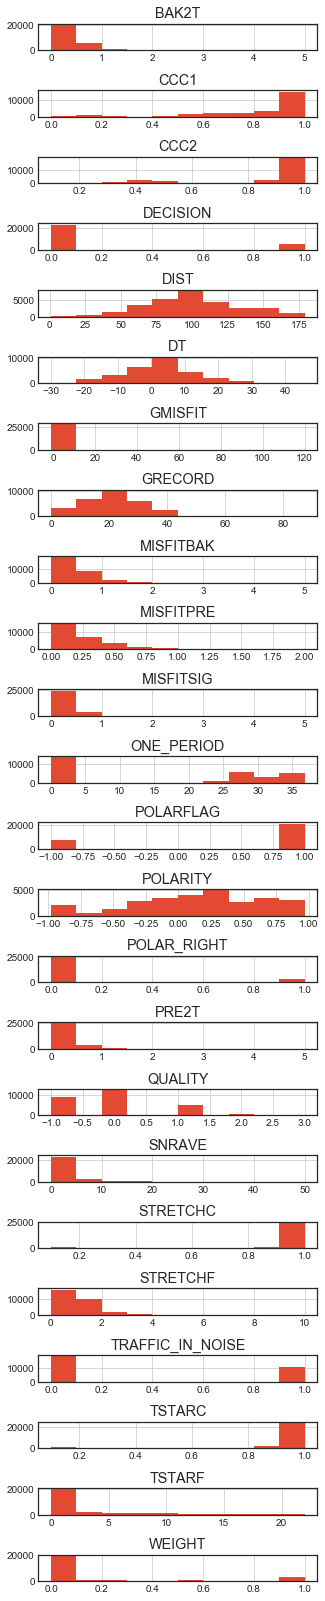

In [73]:
# Clean up outlier
mask =  ( data.BAK2T > 5)
data.loc[mask,"BAK2T"] = 5

mask = (data.MISFITBAK > 5)
data.loc[mask,"MISFITBAK"] = 5

mask = (data.MISFITPRE > 2)
data.loc[mask,"MISFITPRE"] = 2

mask = (data.MISFITSIG > 5)
data.loc[mask,"MISFITSIG"] = 5

mask = (data.PRE2T > 5)
data.loc[mask,"PRE2T"] = 5

mask = (data.SNRAVE > 50)
data.loc[mask,"SNRAVE"] = 50

# mask = (data.SNR_PEAK > 50)
# data.loc[mask,"SNR_PEAK"] = 50
# mask = (data.SNR_PEAK < 0)
# data.loc[mask,"SNR_PEAK"] = 0

# mask = (data.SNR_TROUGH > 50)
# data.loc[mask,"SNR_TROUGH"] = 50
# mask = (data.SNR_TROUGH < 0)
# data.loc[mask,"SNR_TROUGH"] = 0

# Check histograms of all columns
data.hist(layout=(30,1),figsize=(5,36))
plt.subplots_adjust(hspace=1.5)
plt.show()


In [ ]:
#define my features
# data.columns.values
# data.SNR_PEAK

In [74]:
# Use qcut to divide feature value into int
label = LabelEncoder()
# features = ["SNRAVE","CCC1","CCC2","MISFITSIG"]

numerical_feature = [ 'DIST', 'CCC1', 'SNRAVE', 'DT'
       , 'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF',
       'TSTARC', 'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT',
       'POLARITY', 'PRE2T', 'BAK2T',
     'ONE_PERIOD']

catagorial_feature = ['NET', 'POLARFLAG', 'QUALITY',
       'PHASE',
        'POLAR_RIGHT',
        'TRAFFIC_IN_NOISE'
       ]

for feature in numerical_feature:
#     feature_cut = feature+"_Bin"
#     data[feature_cut] = pd.qcut(data[feature],5)
#     feature_format = feature+"_Code"
#     data[feature_format] = label.fit_transform(data[feature_cut]) 
    print("work on ", feature)
    data[feature] = label.fit_transform(pd.qcut(data[feature],8,duplicates='drop'))
    print(data[feature].sample())
    
for feature in catagorial_feature:
    data[feature] = label.fit_transform(data[feature])
    
    

work on  DIST
15414    2
Name: DIST, dtype: int64
work on  CCC1
16633    7
Name: CCC1, dtype: int64
work on  SNRAVE
3425    2
Name: SNRAVE, dtype: int64
work on  DT
5509    4
Name: DT, dtype: int64
work on  STRETCHC
4763    2
Name: STRETCHC, dtype: int64
work on  STRETCHF
19471    4
Name: STRETCHF, dtype: int64
work on  MISFITSIG
10136    6
Name: MISFITSIG, dtype: int64
work on  WEIGHT
17875    3
Name: WEIGHT, dtype: int64
work on  TSTARF
12511    3
Name: TSTARF, dtype: int64
work on  TSTARC
27539    5
Name: TSTARC, dtype: int64
work on  CCC2
14223    0
Name: CCC2, dtype: int64
work on  MISFITPRE
26647    3
Name: MISFITPRE, dtype: int64
work on  MISFITBAK
12756    5
Name: MISFITBAK, dtype: int64
work on  GRECORD
15064    7
Name: GRECORD, dtype: int64
work on  GMISFIT
8843    7
Name: GMISFIT, dtype: int64
work on  POLARITY
8660    2
Name: POLARITY, dtype: int64
work on  PRE2T
3689    5
Name: PRE2T, dtype: int64
work on  BAK2T
11500    0
Name: BAK2T, dtype: int64
work on  ONE_PERIOD
464 

In [75]:
data

,NET,DIST,POLARFLAG,QUALITY,CCC1,SNRAVE,DT,PHASE,STRETCHC,STRETCHF,...,MISFITBAK,GRECORD,GMISFIT,POLARITY,POLAR_RIGHT,PRE2T,BAK2T,TRAFFIC_IN_NOISE,ONE_PERIOD,DECISION
0,83,0,1,3,3,5,7,4,4,6,...,0,3,7,3,0,3,4,0,0,0
1,67,5,0,3,2,5,2,4,4,7,...,3,6,7,1,0,2,3,1,3,0
2,58,6,0,2,3,5,3,4,4,6,...,0,4,7,1,0,3,0,0,1,0
3,58,7,1,0,3,6,6,4,3,6,...,3,4,7,2,0,5,1,0,1,0
4,83,0,1,1,4,0,6,4,3,5,...,5,2,6,2,1,3,4,0,0,0
5,132,0,0,0,2,4,0,4,0,7,...,7,7,7,1,0,2,0,0,4,0
6,132,0,1,0,5,3,2,4,4,2,...,2,1,2,3,0,3,2,0,0,0
7,132,0,1,0,5,3,6,4,3,4,...,2,2,5,4,0,6,0,0,0,0
8,58,0,1,0,5,0,3,4,4,5,...,2,2,6,3,0,5,4,0,0,0
9,30,0,1,1,4,1,2,4,4,6,...,1,3,6,3,0,3,1,0,0,0


In [90]:
# Select features
my_feature_list = list(data.columns)
my_feature_list.remove('DECISION')
my_feature = data[my_feature_list]

my_target = data["DECISION"]


In [91]:
# Double check data to makesure we dont have NaN value
my_feature.isnull().sum()

NET                 0
DIST                0
POLARFLAG           0
QUALITY             0
CCC1                0
SNRAVE              0
DT                  0
PHASE               0
STRETCHC            0
STRETCHF            0
MISFITSIG           0
WEIGHT              0
TSTARF              0
TSTARC              0
CCC2                0
MISFITPRE           0
MISFITBAK           0
GRECORD             0
GMISFIT             0
POLARITY            0
POLAR_RIGHT         0
PRE2T               0
BAK2T               0
TRAFFIC_IN_NOISE    0
ONE_PERIOD          0
dtype: int64

## Data Exploration


In [92]:
my_data = data
# data["DECISION"]

In [93]:
# mydata.drop(["DECISION"],axis=1)
my_data

,NET,DIST,POLARFLAG,QUALITY,CCC1,SNRAVE,DT,PHASE,STRETCHC,STRETCHF,...,MISFITBAK,GRECORD,GMISFIT,POLARITY,POLAR_RIGHT,PRE2T,BAK2T,TRAFFIC_IN_NOISE,ONE_PERIOD,DECISION
0,83,0,1,3,3,5,7,4,4,6,...,0,3,7,3,0,3,4,0,0,0
1,67,5,0,3,2,5,2,4,4,7,...,3,6,7,1,0,2,3,1,3,0
2,58,6,0,2,3,5,3,4,4,6,...,0,4,7,1,0,3,0,0,1,0
3,58,7,1,0,3,6,6,4,3,6,...,3,4,7,2,0,5,1,0,1,0
4,83,0,1,1,4,0,6,4,3,5,...,5,2,6,2,1,3,4,0,0,0
5,132,0,0,0,2,4,0,4,0,7,...,7,7,7,1,0,2,0,0,4,0
6,132,0,1,0,5,3,2,4,4,2,...,2,1,2,3,0,3,2,0,0,0
7,132,0,1,0,5,3,6,4,3,4,...,2,2,5,4,0,6,0,0,0,0
8,58,0,1,0,5,0,3,4,4,5,...,2,2,6,3,0,5,4,0,0,0
9,30,0,1,1,4,1,2,4,4,6,...,1,3,6,3,0,3,1,0,0,0


In [94]:
my_data.columns

Index(['NET', 'DIST', 'POLARFLAG', 'QUALITY', 'CCC1', 'SNRAVE', 'DT', 'PHASE',
       'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF', 'TSTARC',
       'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT', 'POLARITY',
       'POLAR_RIGHT', 'PRE2T', 'BAK2T', 'TRAFFIC_IN_NOISE', 'ONE_PERIOD',
       'DECISION'],
      dtype='object')

In [95]:
# check for correlation between each column and decision
# feature_target.remove("DECISION")
for ff in my_feature_list:
    print(my_data[[ff,"DECISION"]].groupby(ff,as_index=False).mean())






     NET  DECISION
0      0  0.000000
1      1  0.000000
2      2  0.125000
3      3  0.018868
4      4  0.000000
5      5  0.230769
6      6  0.000000
7      7  0.000000
8      8  0.000000
9      9  0.000000
10    10  0.166667
11    11  0.000000
12    12  0.000000
13    13  0.153846
14    14  0.138158
15    15  0.404255
16    16  0.170732
17    17  0.253968
18    18  0.000000
19    19  0.000000
20    20  0.285714
21    21  0.296078
22    22  0.181818
23    23  0.333333
24    24  0.226415
25    25  0.000000
26    26  0.000000
27    27  0.321649
28    28  0.086957
29    29  0.066667
..   ...       ...
211  211  0.282511
212  212  0.081081
213  213  0.065089
214  214  0.063559
215  215  0.152542
216  216  0.750000
217  217  0.000000
218  218  0.000000
219  219  0.040000
220  220  0.000000
221  221  0.000000
222  222  0.000000
223  223  0.250000
224  224  0.000000
225  225  0.000000
226  226  0.000000
227  227  0.250000
228  228  0.000000
229  229  0.000000
230  230  0.000000
231  231  0.

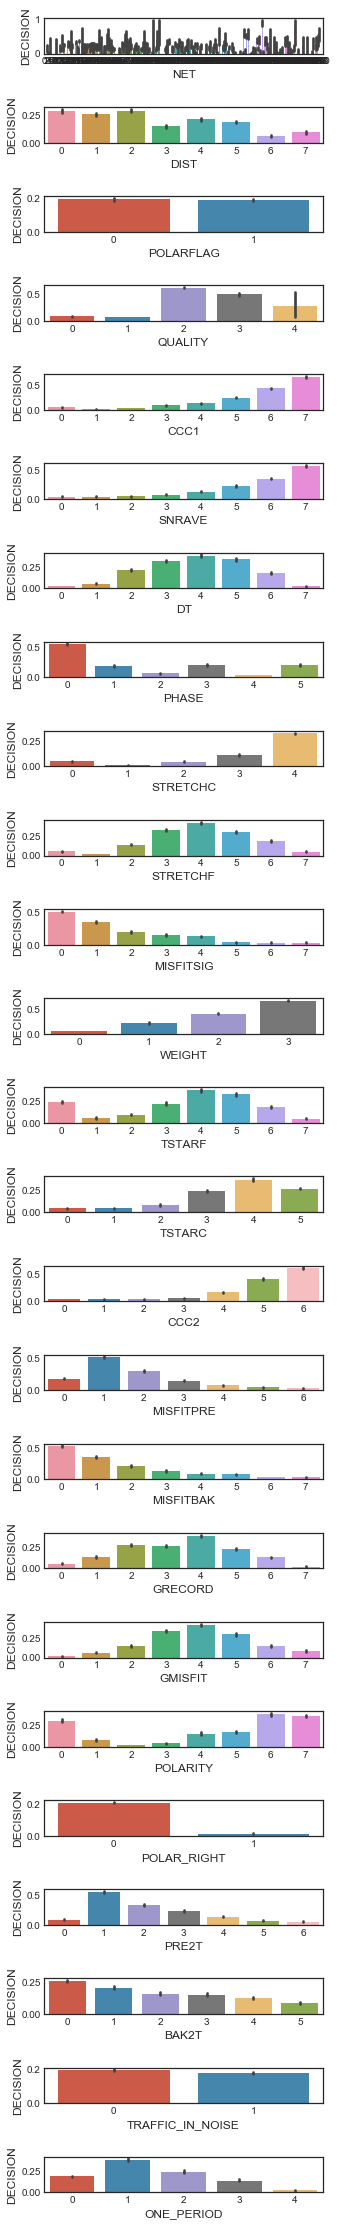

In [97]:
# Virtualize the correlation into figures
fignum = my_feature.shape[1]

fig, axes = plt.subplots(fignum,1,figsize=(5,40))
plt.subplots_adjust(hspace=1.5)

for index,feature in enumerate(my_feature_list):
    sns.barplot(x=feature,y='DECISION',data=data,ax=axes[index])

plt.show()

In [ ]:
# drop columns that does not have strong correlation
# drop_list = ["TRAFFIC_IN_NOISE","POLAR_FLAG"]

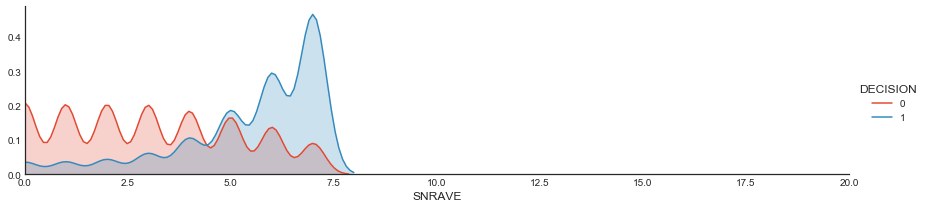

In [98]:
# Show the distribution of SNRAVE between accpeted and rejected record
a = sns.FacetGrid(data,hue="DECISION",aspect=4)
a.map(sns.kdeplot,"SNRAVE",shade=True)
a.set(xlim=(0,20))
a.add_legend()

In [99]:
data.SNRAVE.max()

7

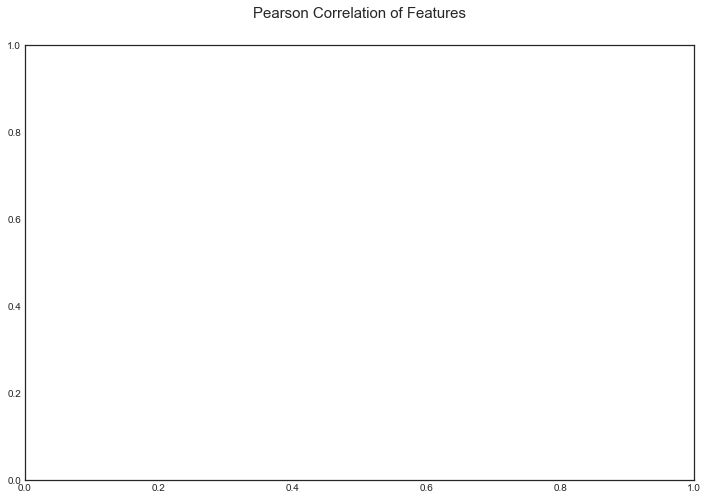

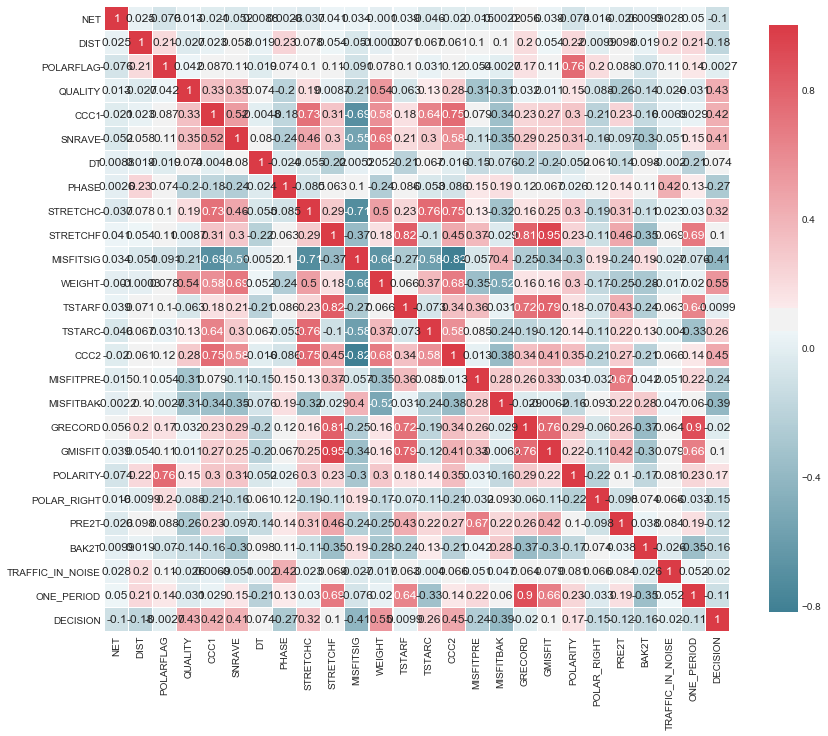

In [100]:
# get Pearson Correlation of Features
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
plt.title("Pearson Correlation of Features",y=1.05,size=15)
correlation_heatmap(data)

In [450]:
# # split data
# x_train, x_test, y_train, y_test = model_selection.train_test_split(
# my_feature,my_target,test_size=0.20,random_state=31)

In [101]:
my_target.value_counts()

0    22930
1     5363
Name: DECISION, dtype: int64

In [139]:
from sklearn.tree import DecisionTreeClassifier as dtree
algs = [LogisticRegression(),dtree(),RandomForestClassifier(),
        KNeighborsClassifier(),GaussianNB()]
MLA_Columns = ["MLA Name","Train Accuracy","Test Accuracy","Time"]
MLA_compare = pd.DataFrame(columns=MLA_Columns)

cv_split = model_selection.ShuffleSplit(n_splits=5,test_size=0.3,
                                       train_size=0.7,random_state=43)

row_index = 0
for alg in algs:
    print(alg)
    cv_result = model_selection.cross_validate(alg,my_feature,my_target,cv=cv_split)
    MLA_compare.loc[row_index,"MLA Name"] = alg.__class__.__name__
    MLA_compare.loc[row_index,"Train Accuracy"] = cv_result["train_score"].mean()
    MLA_compare.loc[row_index,"Test Accuracy"] = cv_result["test_score"].mean()
    MLA_compare.loc[row_index,"Time"] = cv_result["fit_time"].mean()
    row_index+=1
    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbo

In [140]:
MLA_compare.sort_values(by=["Test Accuracy"],ascending=False,inplace=True)
MLA_compare

,MLA Name,Train Accuracy,Test Accuracy,Time
2,RandomForestClassifier,0.994476,0.93393,0.269765
3,KNeighborsClassifier,0.949599,0.928629,0.0697533
1,DecisionTreeClassifier,0.999692,0.908883,0.141757
0,LogisticRegression,0.901383,0.900589,0.416406
4,GaussianNB,0.820318,0.820417,0.0240128


In [472]:
# # Use decision tree to benchmark the dataset to see if decision tree would 
# # be a good model
# my_data = pd.concat([my_feature,my_target],axis=1)
# my_data.columns
# tree = my_data.groupby(["SNRAVE_Code","CCC1_Code","CCC2_Code","MISFITSIG_Code"])["DECISION"].mean()
# tree

Index(['SNRAVE_Code', 'CCC1_Code', 'CCC2_Code', 'MISFITSIG_Code', 'DECISION'], dtype='object')

In [147]:
# # use random forest
# rf = RandomForestClassifier()
# rf_result = model_selection.cross_validate(rf,my_feature,my_target,cv=5)
# rf.fit(my_feature,my_target)
# rf.score(my_feature,my_target)

In [146]:
# Cross validate random forest method
scores = model_selection.cross_val_score(rf, my_feature, my_target, cv=cv_split)
print("Cross Validate Random Forest result: {}".format(scores))
print("Mean is: {}".format(scores.mean()))

Cross Validate Random Forest result: [0.93696984 0.93461357 0.93119698 0.933082   0.92836946 0.93685203
 0.93296418 0.93685203 0.93696984 0.93826579]
Mean is: 0.9346135721017909


In [121]:
# We use dtree and try feature selection
print("BEFORE DT FEATURE SELECTION Train score mean: {:.4f}".format(rf_result["train_score"].mean()))
print("BEFORE DT FEATURE SELECTION Test score mean: {:.4f}".format(rf_result["test_score"].mean()))
print("BEFORE DT FEATURE SELECTION 3std: {:.4f}".format(rf_result["test_score"].std()*3))

rf_rfe = feature_selection.RFECV(rf,step=0.3,scoring='accuracy',cv=cv_split)
rf_rfe.fit(my_feature,my_target)
print(my_feature.columns)
x_rfe = my_feature.columns.values[rf_rfe.get_support()]
x_rfe

BEFORE DT FEATURE SELECTION Train score mean: 0.9948
BEFORE DT FEATURE SELECTION Test score mean: 0.9359
BEFORE DT FEATURE SELECTION 3std: 0.0084
Index(['NET', 'DIST', 'POLARFLAG', 'QUALITY', 'CCC1', 'SNRAVE', 'DT', 'PHASE',
       'STRETCHC', 'STRETCHF', 'MISFITSIG', 'WEIGHT', 'TSTARF', 'TSTARC',
       'CCC2', 'MISFITPRE', 'MISFITBAK', 'GRECORD', 'GMISFIT', 'POLARITY',
       'POLAR_RIGHT', 'PRE2T', 'BAK2T', 'TRAFFIC_IN_NOISE', 'ONE_PERIOD'],
      dtype='object')


array(['NET', 'DIST', 'QUALITY', 'CCC1', 'DT', 'PHASE', 'MISFITSIG',
       'WEIGHT', 'CCC2', 'MISFITBAK', 'POLARITY'], dtype=object)

In [148]:
# use selected feature to train again
new_feature = my_feature[x_rfe]
rf = RandomForestClassifier()
rf2_result = model_selection.cross_validate(rf,new_feature,my_target,cv=cv_split)
print("AFTER DT FEATURE SELECTION Train score mean: {:.4f}".format(rf2_result["train_score"].mean()))
print("AFTER DT FEATURE SELECTION Test score mean: {:.4f}".format(rf2_result["test_score"].mean()))
print("AFTER DT FEATURE SELECTION 3std: {:.4f}".format(rf2_result["test_score"].std()*3))

AFTER DT FEATURE SELECTION Train score mean: 0.9925
AFTER DT FEATURE SELECTION Test score mean: 0.9312
AFTER DT FEATURE SELECTION 3std: 0.0085
